In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')

In [62]:
# Load data
train_df = pd.read_csv('../data/raw/train_data.csv')
submission_df = pd.read_csv('../data/raw/submission_data.csv')
template_df = pd.read_csv('../data/processed/submission_template.csv')

In [63]:
# Replace placeholders with NaN
train_df.replace([-1, -1.0, '-1', '-1.0'], np.nan, inplace=True)
submission_df.replace([-1, -1.0, '-1', '-1.0'], np.nan, inplace=True)


In [64]:
# Convert date columns to datetime
date_cols = ["launch_date", "ind_launch_date", "date"]
for col in date_cols:
    train_df[col] = pd.to_datetime(train_df[col], errors='coerce')
    submission_df[col] = pd.to_datetime(submission_df[col], errors='coerce')


In [65]:
# Feature Engineering Functions
def extract_date_features(df):
    df['launch_year'] = df['launch_date'].dt.year
    df['launch_month'] = df['launch_date'].dt.month
    df['launch_day'] = df['launch_date'].dt.day
    df['ind_launch_year'] = df['ind_launch_date'].dt.year
    df['ind_launch_month'] = df['ind_launch_date'].dt.month
    df['ind_launch_day'] = df['ind_launch_date'].dt.day
    df['date_year'] = df['date'].dt.year
    df['date_month'] = df['date'].dt.month
    df['date_day'] = df['date'].dt.day
    # Time since launch
    # Calculate months_since_launch
    df['months_since_launch'] = (
        (df['date'].dt.year - df['launch_date'].dt.year) * 12 +
        (df['date'].dt.month - df['launch_date'].dt.month)
    ).fillna(0)
    df['months_since_ind_launch'] = (
        (df['date'].dt.year - df['ind_launch_date'].dt.year) * 12 +
        (df['date'].dt.month - df['ind_launch_date'].dt.month)
    ).fillna(0)   
    
    # Cyclical features
    df['month_sin'] = np.sin(2 * np.pi * df['date_month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['date_month'] / 12)
    return df

def create_market_features(df):
    df['market_size'] = df['population'] * df['prev_perc']
    df['affordability_index'] = df['che_pc_usd'] / df['price_month']
    df['price_insurance_interaction'] = df['price_month'] * (1 - df['insurance_perc_che'])
    return df

# Handle 'indication' feature (pre multi-label encoding)
def process_indication(df):
    df['indication'] = df['indication'].apply(lambda x: eval(x) if pd.notnull(x) else [])
    return df

# Apply feature engineering functions
train_df        = extract_date_features(train_df)
submission_df   = extract_date_features(submission_df)
train_df        = create_market_features(train_df)
submission_df   = create_market_features(submission_df)
train_df        = process_indication(train_df)
submission_df   = process_indication(submission_df)

In [66]:
# Split the data into training and testing sets based on launch_date
perc_train_samples = 0.8
launches = train_df.groupby('cluster_nl')['launch_date'].first().reset_index()
launches = launches.sort_values('launch_date')
cutoff = int(len(launches) * perc_train_samples)
cutoff_launch_date = launches.iloc[cutoff]['launch_date']
train_cluster_nls = launches.iloc[:cutoff]['cluster_nl']
test_cluster_nls = launches.iloc[cutoff:]['cluster_nl']

train_data = train_df.loc[train_df['cluster_nl'].isin(train_cluster_nls)]
test_data = train_df.loc[train_df['cluster_nl'].isin(test_cluster_nls)]

# Separate features and target
X_train = train_data.drop(columns=['target'])
y_train = train_data['target']

X_test = test_data.drop(columns=['target'])
y_test = test_data['target']

# Save cluster_nl and date for metric computation
metric_df = test_data[['cluster_nl', 'date', 'target']].copy()

In [67]:
# Define columns
numeric_features = [
    'che_pc_usd', 'che_perc_gdp', 'insurance_perc_che', 'population', 'prev_perc', 
    'price_month', 'price_unit', 'public_perc_che', 'months_since_launch', 
    'months_since_ind_launch', 'market_size', 'affordability_index', 
    'price_insurance_interaction', 'month_sin', 'month_cos'
]

categorical_features_low = ['corporation', 'country', 'therapeutic_area']
categorical_features_high = ['brand', 'drug_id']

# Process 'indication' with MultiLabelBinarizer
class IndicationTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer(sparse_output=False)
        
    def fit(self, X, y=None):
        self.mlb.fit(X['indication'])
        return self
    
    def transform(self, X):
        indication_encoded = self.mlb.transform(X['indication'])
        indication_df = pd.DataFrame(indication_encoded, columns=self.mlb.classes_, index=X.index)
        X = X.join(indication_df)
        X = X.drop(columns=['indication'])
        return X

# Define custom transformer for target encoding within ColumnTransformer
class TargetEncodingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.encoders = {}
        
    def fit(self, X, y):
        for col in self.cols:
            encoder = TargetEncoder()
            encoder.fit(X[col], y)
            self.encoders[col] = encoder
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for col in self.cols:
            X_transformed[col] = self.encoders[col].transform(X[col])
        return X_transformed


In [68]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer_low = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

categorical_transformer_high = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("target_encoder", TargetEncoder())
])

# Combine all preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat_low", categorical_transformer_low, categorical_features_low),
        ("cat_high", categorical_transformer_high, categorical_features_high)
    ]
)

# Full pipeline
pipeline = Pipeline(steps=[
    ("indication_transformer", IndicationTransformer()),
    ("preprocessor", preprocessor),
    # Remove StandardScaler if not needed
    # ("scaler", StandardScaler()),
    ("regressor", xgb.XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        tree_method="gpu_hist",
        predictor='gpu_predictor', 
    ))
])


X_train_indication_transformed = IndicationTransformer().fit_transform(X_train, y_train)
X_train_preprocessed = preprocessor.fit_transform(X_train_indication_transformed, y_train)

X_train_preprocessed

array([[1.20911361, 1.6658786 , 1.89333333, ..., 0.        , 1.19751762,
        1.20098598],
       [1.51825843, 1.7533377 , 1.54666667, ..., 0.        , 1.16390056,
        1.16390056],
       [1.20911361, 1.6658786 , 1.89333333, ..., 0.        , 1.09188894,
        1.09188894],
       ...,
       [1.27082673, 1.68406509, 1.44      , ..., 1.        , 1.00544474,
        1.01182157],
       [1.75623439, 1.81948475, 1.17333333, ..., 0.        , 1.10345862,
        1.17993439],
       [1.12749688, 1.4915517 , 1.82666667, ..., 0.        , 1.49550679,
        1.47802905]])

In [69]:
pipeline_no_preprocessor = Pipeline(steps=[
    ("regressor", xgb.XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        tree_method="gpu_hist",
        predictor='gpu_predictor'
    ))
])


# Custom CYME metric
def cyme_metric(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    ape = ape.replace([np.inf, -np.inf], np.nan).dropna()
    median_ape = np.median(ape)
    return median_ape

cyme_scorer = make_scorer(cyme_metric, greater_is_better=False)

In [70]:
# Hyperparameter tuning
param_dist = {
    "regressor__n_estimators": [50, 100, 300],
    "regressor__learning_rate": [0.1, 0.01, 0.001],
    "regressor__max_depth": [5, 10, 20],
   # "regressor__subsample": [0.7, 0.9, 1.0],
   # "regressor__colsample_bytree": [0.7, 0.9, 1.0]
}

# Time-based cross-validation
tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_iter=10, 
    cv=tscv, 
    scoring=cyme_scorer, 
    verbose=2, 
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=Pipeline(steps=[('indication_transformer',
                                              IndicationTransformer()),
                                             ('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['che_pc_usd',
                                                                                'che_perc_gdp',
                                                                                'insurance_perc_che',
                                                                                'population',
                                                                                '...
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           predictor='gpu_predictor', ...))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'regressor__learning_rate': [0.1, 0.01,
                                                                     0.001],
                                        'regressor__max_depth': [5, 10, 20],
                                        'regressor__n_estimators': [50, 100,
                                                                    300]},
                   random_state=42,
                   scoring=make_scorer(cyme_metric, greater_is_better=False, response_method='predict'),
                   verbose=2)

In [71]:
best_model = random_search.best_estimator_

# Evaluate the model
def predict_and_measure_performance(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE:  {mse}")
    # Assuming unaveraged_CYME is defined appropriately
    cyme = cyme_metric(y_test, y_pred)
    print(f"CYME: {cyme}")
    return mse, cyme

mse, cyme = predict_and_measure_performance(best_model, X_test, y_test)


MSE:  0.3825257264203927
CYME: 0.06267224546891542


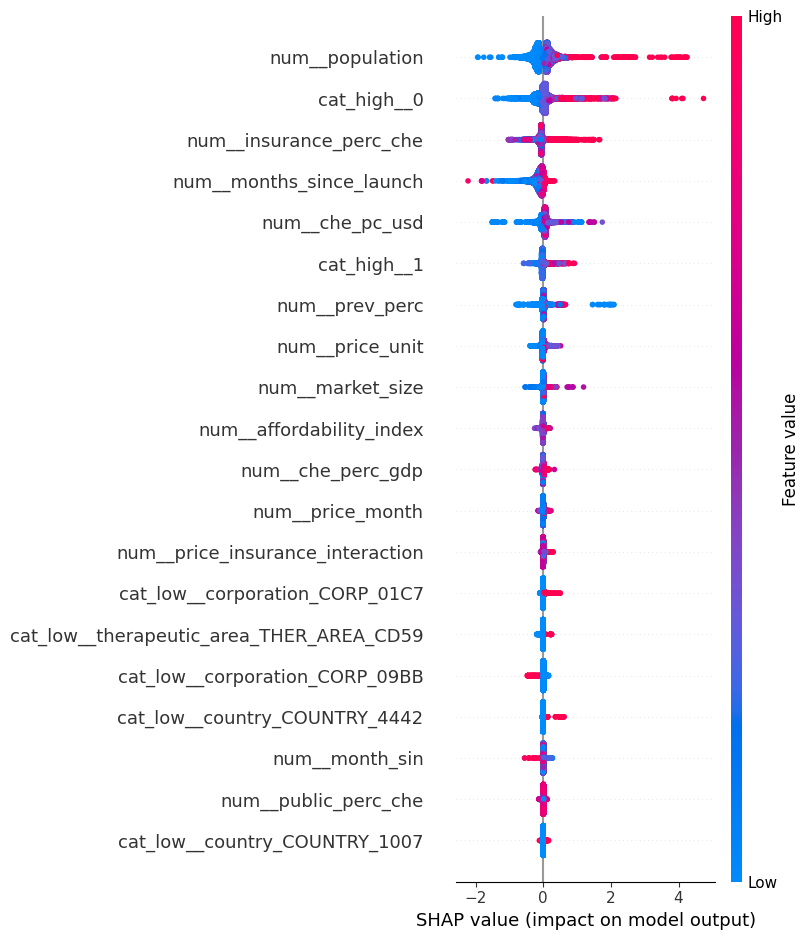

In [72]:
# Feature Importance using SHAP
xgb_regressor = best_model.named_steps["regressor"]

# Prepare data for SHAP
X_test_transformed = best_model.named_steps["preprocessor"].transform(X_test)
explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(X_test_transformed)

# Plot summary plot
feature_names = best_model.named_steps["preprocessor"].get_feature_names_out()
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)


## Prepare submission

In [73]:
# Predict on submission data
predictions = best_model.predict(submission_df)

In [74]:
submission_df

,brand,che_pc_usd,che_perc_gdp,cluster_nl,corporation,country,launch_date,date,drug_id,ind_launch_date,...,date_year,date_month,date_day,months_since_launch,months_since_ind_launch,month_sin,month_cos,market_size,affordability_index,price_insurance_interaction
0,BRAND_E57A,2.079046,1.467920,BRAND_E57A_COUNTRY_06E4,CORP_01C7,COUNTRY_06E4,2022-02-01,2023-01-01,DRUG_ID_FADD,2022-08-01,...,2023,1,1,11,5.0,5.000000e-01,0.866025,0.036821,2.064407,0.000000
1,BRAND_014B,2.079046,1.467920,BRAND_014B_COUNTRY_06E4,CORP_01C7,COUNTRY_06E4,2022-09-01,2023-01-01,DRUG_ID_E07F,NaT,...,2023,1,1,4,0.0,5.000000e-01,0.866025,0.107432,NaN,NaN
2,BRAND_1E6F,1.018268,1.108030,BRAND_1E6F_COUNTRY_4647,CORP_01C7,COUNTRY_4647,2022-05-01,2023-01-01,DRUG_ID_1A21,2022-06-01,...,2023,1,1,8,7.0,5.000000e-01,0.866025,0.133493,NaN,NaN
3,BRAND_9259,1.190075,1.515375,BRAND_9259_COUNTRY_FA79,CORP_01C7,COUNTRY_FA79,2022-12-01,2023-01-01,DRUG_ID_1315,NaT,...,2023,1,1,1,0.0,5.000000e-01,0.866025,0.002884,NaN,NaN
4,BRAND_106A,1.018876,1.127864,BRAND_106A_COUNTRY_E319,CORP_DF1B,COUNTRY_E319,2022-12-01,2023-01-01,DRUG_ID_2832,2020-03-01,...,2023,1,1,1,34.0,5.000000e-01,0.866025,0.000251,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,BRAND_740F,2.709582,2.011926,BRAND_740F_COUNTRY_3AD0,CORP_01C7,COUNTRY_3AD0,2022-01-01,2023-12-01,DRUG_ID_C6D4,2022-08-01,...,2023,12,1,23,16.0,-2.449294e-16,1.000000,0.028717,2.695517,-0.576325
1765,BRAND_056A,1.982740,1.915414,BRAND_056A_COUNTRY_4442,CORP_01C7,COUNTRY_4442,2022-09-01,2023-12-01,DRUG_ID_EC3A,2022-09-01,...,2023,12,1,15,15.0,-2.449294e-16,1.000000,0.001504,1.588615,0.000000
1766,BRAND_F649,1.186954,1.493446,BRAND_F649_COUNTRY_9488,CORP_01C7,COUNTRY_9488,2023-11-01,2023-12-01,DRUG_ID_20C2,2024-11-01,...,2023,12,1,1,-11.0,-2.449294e-16,1.000000,0.009347,0.991846,-0.975615
1767,BRAND_DB5A,1.186954,1.493446,BRAND_DB5A_COUNTRY_9488,CORP_01C7,COUNTRY_9488,2023-11-01,2023-12-01,DRUG_ID_2910,2024-11-01,...,2023,12,1,1,-11.0,-2.449294e-16,1.000000,0.672801,1.087538,-0.889771


In [75]:
# Merge predictions with template
submission_df['prediction'] = predictions
submission_df['date'] = pd.to_datetime(submission_df['date'], errors='coerce')
template_df['date'] = pd.to_datetime(template_df['date'], errors='coerce')
template_df = template_df.drop(columns=['prediction'])
final_submission = template_df.merge(
    submission_df[['cluster_nl', 'date', 'prediction']],
    on=['cluster_nl', 'date'],
    how='left'
)

In [76]:
final_submission

,date,cluster_nl,prediction
0,2023-01-01,BRAND_9259_COUNTRY_6B71,1.105619
1,2023-02-01,BRAND_9259_COUNTRY_6B71,1.099497
2,2023-03-01,BRAND_9259_COUNTRY_6B71,1.145324
3,2023-04-01,BRAND_9259_COUNTRY_6B71,1.110577
4,2023-05-01,BRAND_9259_COUNTRY_6B71,1.133834
...,...,...,...
1764,2023-08-01,BRAND_056A_COUNTRY_3536,1.054013
1765,2023-09-01,BRAND_056A_COUNTRY_3536,1.062693
1766,2023-10-01,BRAND_056A_COUNTRY_3536,1.084852
1767,2023-11-01,BRAND_056A_COUNTRY_3536,1.093126


In [77]:
# Fill missing predictions with zeros or appropriate values
final_submission['prediction'] = final_submission['prediction'].fillna(0)

# Save the submission file
final_submission[['cluster_nl', 'date', 'prediction']].to_csv('../data/outputs/final_submission.csv', index=False)
